In [1]:
import pathlib
import pickle
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import torch
from rdkit.Chem import rdmolops

In [2]:
def gather_single_results(subfolder: pathlib.Path):
    with open(subfolder / "SMILES.txt") as f:
        smiles = f.read().splitlines()
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    if (subfolder/"log_densities.npy").exists():
        densities = np.load(subfolder / "log_densities.npy")
    else:
        densities = None
    if (subfolder/"log_densities_no_h.npy").exists():
        densities_no_h = np.load(subfolder / "log_densities_no_h.npy")
    else:
        densities_no_h = None
    moldiff_metrics_folder = subfolder / "metrics"
    if moldiff_metrics_folder.exists():
        with open(moldiff_metrics_folder / "mols_local3d.pkl", "rb") as f:
            local3d_metrics = pickle.load(f)
        synthesizability_metrics = pd.read_csv(moldiff_metrics_folder / "mols.csv", index_col=0)
        with open(moldiff_metrics_folder / "mols_similarity.pkl", "rb") as f:
            similarity_metics = pickle.load(f)
    else:
        local3d_metrics = None
        synthesizability_metrics = None
        similarity_metics = None
    return {
        "smiles": smiles,
        "mols": mols,
        "logdens": densities,
        "logdens_no_h": densities_no_h,
        "local3d_metrics": local3d_metrics,
        "synthesizability_metrics": synthesizability_metrics,
        "similarity_metrics": similarity_metics
    }

In [3]:
all_results = {}
results_path = pathlib.Path("./results_production/")
for subfolder in results_path.iterdir():
    if subfolder.is_dir():
        all_results[subfolder.name] = gather_single_results(subfolder)

In [4]:
scaffolded_results_path = pathlib.Path("./results_production_scaffolded/")
for subfolder in scaffolded_results_path.iterdir():
    if subfolder.is_dir():
        all_results[subfolder.name] = gather_single_results(subfolder)

In [5]:
for key, values in all_results.items():
    mol_list = values["mols"]
    num_frags = np.array(
        [len(rdmolops.GetMolFrags(mol, asMols=True)) for mol in mol_list]
    )
    values["fragmented_frac"] = (num_frags > 1).mean()

In [6]:
penicillin_mol = Chem.MolFromSmiles("CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O")
penicillin_fp = Chem.RDKFingerprint(penicillin_mol)

lactam_patt = Chem.MolFromSmarts("O=[#6]1[#7][#6][#6]1")
thio_ring_patt = Chem.MolFromSmarts("[*]1[#16][*][*][*]1")
thio_ring_strict = Chem.MolFromSmarts("[*]1[#16][*][#7][*]1")

In [7]:
mean_logdens = {k: np.median(v["logdens"]) for k, v in all_results.items()}
top_logdens = {k: np.mean(np.sort(v["logdens"])[-5:]) for k, v in all_results.items()}
mean_logdens_no_h = {k: np.median(v["logdens_no_h"]) for k, v in all_results.items()}
top_logdens_no_h = {k: np.mean(np.sort(v["logdens_no_h"])[-5:]) for k, v in all_results.items()}

In [8]:
has_lactam = {
    k: [mol.HasSubstructMatch(lactam_patt) for mol in v["mols"]]
    for k, v in all_results.items()
}
has_thio_ring = {
    k: [mol.HasSubstructMatch(thio_ring_patt) for mol in v["mols"]]
    for k, v in all_results.items()
}
has_thio_ring_strict = {
    k: [mol.HasSubstructMatch(thio_ring_strict) for mol in v["mols"]]
    for k, v in all_results.items()
}
has_both_strict = {
    k: [
        mol.HasSubstructMatch(lactam_patt) and mol.HasSubstructMatch(thio_ring_strict)
        for mol in v["mols"]
    ]
    for k, v in all_results.items()
}
has_both = {
    k: [
        mol.HasSubstructMatch(lactam_patt) and mol.HasSubstructMatch(thio_ring_patt)
        for mol in v["mols"]
    ]
    for k, v in all_results.items()
}

In [9]:
num_lactams = {k: np.sum(v) for k, v in has_lactam.items()}
num_thio_rings = {k: np.sum(v) for k, v in has_thio_ring.items()}
num_both = {k: np.sum(v) for k, v in has_both.items()}
num_both_strict = {k: np.sum(v) for k, v in has_both_strict.items()}
num_both

{'inv_sum_gui_is_only_low_t_no_h_ref': 0,
 'direct_sum_gui_is': 0,
 'direct_sum_gui_no_is_no_h_ref': 1,
 'direct_sum_gui_no_is': 0,
 'inv_sum_gui_no_is': 5,
 'inv_sum_gui_is_low_t': 3,
 'direct_sum_gui_is_only_low_t': 1,
 'inv_sum_gui_no_is_no_h_ref': 11,
 'direct_sum_gui_is_low_t': 0,
 'pure_moldiff': 0,
 'direct_sum_gui_is_low_t_no_h_ref': 1,
 'inv_sum_gui_is_low_t_no_h_ref': 16,
 'inv_sum_gui_is_only_no_h_ref': 0,
 'direct_sum_gui_is_no_h_ref': 1,
 'inv_sum_gui_is': 6,
 'direct_sum_gui_is_only': 0,
 'inv_sum_gui_is_only': 0,
 'direct_sum_gui_is_only_no_h_ref': 0,
 'inv_sum_gui_is_no_h_ref': 44,
 'inv_sum_gui_is_only_low_t': 0,
 'direct_sum_gui_is_only_low_t_no_h_ref': 1,
 'fixed_scaffoled_no_readd_noise': 10,
 'fixed_scaffoled_readd_noise': 36}

In [10]:
from scipy.spatial.distance import jensenshannon


def js_single(query_dict:dict, ref_dict:dict, key:str, min_val:float, max_val:float, num_bins=100):
    ref_vals = np.concatenate([v for v in ref_dict[key].values()])
    query_vals = np.concatenate([v for v in query_dict[key].values()])
    bins = np.linspace(min_val, max_val, num_bins)
    ref_hist, _ = np.histogram(ref_vals, bins=bins, density=True)
    query_hist, _ = np.histogram(query_vals, bins=bins, density=True)
    return jensenshannon(ref_hist, query_hist)

def calculate_local3d_shifts(
    target_3d_results,
    ref_3d_results,
    num_bins=100,
    min_length: float = 0.8,
    max_length: float = 2.2,
):
    length_dist = js_single(target_3d_results, ref_3d_results, "lengths", min_length, max_length, num_bins)
    angle_dist = js_single(target_3d_results, ref_3d_results, "angles", 0, 180, num_bins)
    dihedral_dist = js_single(target_3d_results, ref_3d_results, "dihedral", -180, 180, num_bins)
    return length_dist, angle_dist, dihedral_dist

In [11]:
all_results["pure_moldiff"]["similarity_metrics"]

{'novelty': 0.9709868295476236,
 'uniqueness': 0.9085703378507348,
 'diversity': [0.8961633899599161, 0.559457911815232, 0.1315136476426799],
 'sim_with_val': (0.005153655277724756,
  0.2626455430425654,
  0.8259209772857415,
  0.6200432649722807),
 'sim_with_train': (0.052300057262836416,
  0.5132658904371064,
  0.9234586753197175,
  0.7064054764593239)}

In [12]:
all_results.keys()

dict_keys(['inv_sum_gui_is_only_low_t_no_h_ref', 'direct_sum_gui_is', 'direct_sum_gui_no_is_no_h_ref', 'direct_sum_gui_no_is', 'inv_sum_gui_no_is', 'inv_sum_gui_is_low_t', 'direct_sum_gui_is_only_low_t', 'inv_sum_gui_no_is_no_h_ref', 'direct_sum_gui_is_low_t', 'pure_moldiff', 'direct_sum_gui_is_low_t_no_h_ref', 'inv_sum_gui_is_low_t_no_h_ref', 'inv_sum_gui_is_only_no_h_ref', 'direct_sum_gui_is_no_h_ref', 'inv_sum_gui_is', 'direct_sum_gui_is_only', 'inv_sum_gui_is_only', 'direct_sum_gui_is_only_no_h_ref', 'inv_sum_gui_is_no_h_ref', 'inv_sum_gui_is_only_low_t', 'direct_sum_gui_is_only_low_t_no_h_ref', 'fixed_scaffoled_no_readd_noise', 'fixed_scaffoled_readd_noise'])

In [13]:
import numpy as np
import pandas as pd


def build_results_table(
    all_results: dict,
    has_lactam: dict,
    has_thio_ring: dict,
    reference_key: str = "pure_moldiff",
    num_bins: int = 50,
):
    # Special renames for unguided models
    unguided_renames = {
        "pure_moldiff": "MolDiff",
        "fixed_scaffoled_readd_noise": "MolDiff (Outpainting)"
        # Add any other mappings here:
        # "another_key": "Your custom label"
    }

    # Helper to turn "Yes"/"No" into ticks/crosses
    def yes_no_to_mark(val: str) -> str:
        return "✓" if val.lower() == "yes" else "✗"

    # Helper to parse and rename index
    def make_index_human_readable(k: str) -> str|None:
        # If it's an unguided row that appears in unguided_renames, use that mapping
        if k in unguided_renames:
            return unguided_renames[k]
        # Otherwise, determine if it's direct or inverse guidance
        if "direct_sum" in k:
            guidance = "Guidance Direct"
        elif "inv_sum" in k:
            guidance = "Guidance Inverse"
        else:
            return None

        # "gui_no" => IS No => "✗", else => "✓"
        if "gui_no_is" in k:
            is_val = "No"
        else:
            is_val = "Yes"

        # If "_is" is in k => Score Yes => "✓", else => "✗"
        if "_is_only" in k:
            score_val = "No"
        else:
            score_val = "Yes"

        return f"{guidance}, IS {yes_no_to_mark(is_val)}, Score {yes_no_to_mark(score_val)}"

    ref_3d_metrics = all_results[reference_key]["local3d_metrics"]
    table_data = []
    indices = []

    # ----------------------
    # Build raw data
    # ----------------------
    for k, v in all_results.items():
        # Skip rows with "_low_t"
        if "_low_t" in k:
            continue
        # If it's direct_sum or inv_sum, only keep if "no_h_ref" is present
        if ("direct_sum" in k or "inv_sum" in k) and "no_h_ref" not in k:
            continue
        if "fixed_scaffoled_no_readd_noise" == k:
            continue

        # Fraction fragmented
        fragmented_frac = v["fragmented_frac"]

        # Lactams and thio rings
        num_lact = np.mean(has_lactam[k]) if k in has_lactam else 0
        num_thio = np.mean(has_thio_ring[k]) if k in has_thio_ring else 0
        num_both = (
            np.sum([x and y for x, y in zip(has_lactam[k], has_thio_ring[k])])
            if k in has_lactam and k in has_thio_ring
            else 0
        )

        # Synthesizability metrics
        if v["synthesizability_metrics"] is not None:
            mean_vals = v["synthesizability_metrics"][["qed", "sa", "lipinski"]].mean()
            mean_qed, mean_sa, mean_lip = (
                mean_vals["qed"],
                mean_vals["sa"],
                mean_vals["lipinski"],
            )
        else:
            mean_qed, mean_sa, mean_lip = None, None, None

        # JS distances
        length_js, angle_js, dihedral_js = calculate_local3d_shifts(
            v["local3d_metrics"], ref_3d_metrics, num_bins
        )

        # Diversity and similarity
        similarity_metrics = v["similarity_metrics"]
        novelty = similarity_metrics["novelty"]
        uniqueness = similarity_metrics["uniqueness"]
        div_95, div_70, div_50 = similarity_metrics["diversity"]
        sim_95, sim_70, sim_50, _ = similarity_metrics["sim_with_train"]

        indices.append(k)
        data = {
            "fragmented_frac": fragmented_frac,
            "num_lactams": num_lact,
            "num_thiophenes": num_thio,
            "num_both": num_both,
            "mean_QED": mean_qed,
            "mean_SA": mean_sa,
            "mean_Lipinski": mean_lip,
            "JS_length": length_js,
            "JS_angle": angle_js,
            "JS_dihedral": dihedral_js,
            "novelty": novelty,
            "uniqueness": uniqueness,
            "diversity_0.95": div_95,
            "diversity_0.70": div_70,
            "diversity_0.50": div_50,
            "similarity_0.95": sim_95,
            "similarity_0.70": sim_70,
            "similarity_0.50": sim_50,
        }
        table_data.append(data)

    # ----------------------
    # Format numeric columns
    # ----------------------
    base_lactam_frac = np.mean(has_lactam[reference_key])
    base_thio_frac = np.mean(has_thio_ring[reference_key])
    res_format = "{:3.1%} ({:2.1f})"

    for data in table_data:
        data["num_lactams"] = res_format.format(
            data["num_lactams"], data["num_lactams"] / base_lactam_frac
        )
        data["num_thiophenes"] = res_format.format(
            data["num_thiophenes"], data["num_thiophenes"] / base_thio_frac
        )
        for col, val in data.items():
            if isinstance(val, float):
                data[col] = f"{val:.2f}"

    # ----------------------
    # Build final DataFrame
    # ----------------------
    new_indices = [make_index_human_readable(k) for k in indices]
    df = pd.DataFrame(table_data, index=new_indices)

    # Rename columns
    df = df.rename(
        columns={
            "fragmented_frac": ("", "Fragmented Fraction"),
            "num_lactams": ("Targeted Substructures", "Frac. with lactam"),
            "num_thiophenes": ("Targeted Substructures", "Frac. with thiophene"),
            "num_both": ("Targeted Substructures", "Num. with both"),
            "mean_QED": ("Drug-likeness", "QED"),
            "mean_SA": ("Drug-likeness", "SA"),
            "mean_Lipinski": ("Drug-likeness", "Lipinski"),
            "JS_length": ("JS distance rel. to Unguided Model", "length"),
            "JS_angle": ("JS distance rel. to Unguided Model", "angle"),
            "JS_dihedral": ("JS distance rel. to Unguided Model", "dihedral"),
            "diversity_0.95": ("Diversity", "0.95"),
            "diversity_0.70": ("Diversity", "0.70"),
            "diversity_0.50": ("Diversity", "0.50"),
            "similarity_0.95": ("Similarity", "0.95"),
            "similarity_0.70": ("Similarity", "0.70"),
            "similarity_0.50": ("Similarity", "0.50"),
        }
    )
    df.columns = pd.MultiIndex.from_tuples(
        c if isinstance(c, tuple) else ("", c) for c in df.columns
    )
    order = [
        "MolDiff",
        "MolDiff (Outpainting)",
        "Guidance Direct, IS ✗, Score ✓",
        "Guidance Direct, IS ✓, Score ✗",
        "Guidance Direct, IS ✓, Score ✓",
        "Guidance Inverse, IS ✗, Score ✓",
        "Guidance Inverse, IS ✓, Score ✗",
        "Guidance Inverse, IS ✓, Score ✓",
    ]
    df = df.loc[order]
    return df


In [14]:
df = build_results_table(all_results, has_lactam, has_thio_ring)
df

Targeted Substructures  \
                                Fragmented Fraction      Frac. with lactam   
MolDiff                                        0.01             0.2% (1.0)   
MolDiff (Outpainting)                          0.03           13.7% (55.2)   
Guidance Direct, IS ✗, Score ✓                 0.02             0.1% (0.5)   
Guidance Direct, IS ✓, Score ✗                 0.01             0.2% (0.8)   
Guidance Direct, IS ✓, Score ✓                 0.03             0.2% (1.0)   
Guidance Inverse, IS ✗, Score ✓                0.08             2.1% (8.3)   
Guidance Inverse, IS ✓, Score ✗                0.01             0.2% (0.8)   
Guidance Inverse, IS ✓, Score ✓                0.08            3.7% (14.9)   

                                                                     \
                                Frac. with thiophene Num. with both   
MolDiff                                   5.4% (1.0)              0   
MolDiff (Outpainting)                    32.0% (5.9)             36   
Guidance Direct, IS ✗, Score ✓            9.6% (1.8)              1   
Guidance Direct, IS ✓, Score ✗            6.4% (1.2)              0   
Guidance Direct, IS ✓, Score ✓            8.7% (1.6)              1   
Guidance Inverse, IS ✗, Score ✓          16.5% (3.1)             11   
Guidance Inverse, IS ✓, Score ✗           7.9% (1.5)              0   
Guidance Inverse, IS ✓, Score ✓          21.9% (4.0)             44   

                                Drug-likeness                 \
                                          QED    SA Lipinski   
MolDiff                                  0.77  0.85     5.00   
MolDiff (Outpainting)                    0.68  0.57     5.00   
Guidance Direct, IS ✗, Score ✓           0.78  0.87     4.99   
Guidance Direct, IS ✓, Score ✗           0.77  0.85     5.00   
Guidance Direct, IS ✓, Score ✓           0.75  0.85     4.98   
Guidance Inverse, IS ✗, Score ✓          0.75  0.82     4.99   
Guidance Inverse, IS ✓, Score ✗          0.76  0.84     5.00   
Guidance Inverse, IS ✓, Score ✓          0.75  0.78     4.99   

                                JS distance rel. to Unguided Model        \
                                                            length angle   
MolDiff                                                       0.00  0.00   
MolDiff (Outpainting)                                         0.32  0.36   
Guidance Direct, IS ✗, Score ✓                                0.07  0.05   
Guidance Direct, IS ✓, Score ✗                                0.02  0.02   
Guidance Direct, IS ✓, Score ✓                                0.10  0.08   
Guidance Inverse, IS ✗, Score ✓                               0.19  0.15   
Guidance Inverse, IS ✓, Score ✗                               0.02  0.01   
Guidance Inverse, IS ✓, Score ✓                               0.22  0.19   

                                                            Diversity        \
                                dihedral novelty uniqueness      0.95  0.70   
MolDiff                             0.00    0.97       0.91      0.90  0.56   
MolDiff (Outpainting)               0.37    1.00       1.00      1.00  0.73   
Guidance Direct, IS ✗, Score ✓      0.04    0.98       0.93      0.92  0.55   
Guidance Direct, IS ✓, Score ✗      0.02    0.98       0.79      0.77  0.56   
Guidance Direct, IS ✓, Score ✓      0.08    0.99       0.82      0.80  0.56   
Guidance Inverse, IS ✗, Score ✓     0.18    1.00       0.99      0.99  0.75   
Guidance Inverse, IS ✓, Score ✗     0.02    0.98       0.73      0.72  0.52   
Guidance Inverse, IS ✓, Score ✓     0.22    1.00       0.84      0.82  0.67   

                                      Similarity              
                                 0.50       0.95  0.70  0.50  
MolDiff                          0.13       0.05  0.51  0.92  
MolDiff (Outpainting)            0.10       0.00  0.20  0.90  
Guidance Direct, IS ✗, Score ✓   0.14       0.04  0.58  0.93  
Guidance Direct, IS ✓, Score ✗   0.17       0.04  0.

In [15]:
df.to_csv("./results_summary.csv")

In [16]:
import seaborn as sns

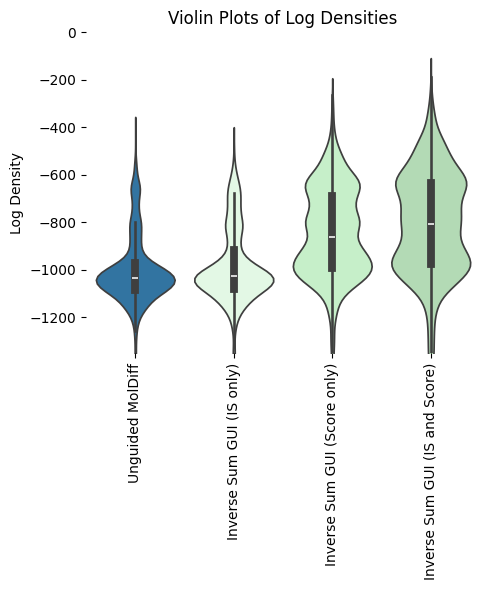

In [27]:
readable_names = {
    "pure_moldiff": "Unguided MolDiff",
    "direct_sum_gui_is_no_h_ref": "Direct Sum GUI (IS and Score)",
    "direct_sum_gui_is_only_no_h_ref": "Direct Sum GUI (IS only)",
    "direct_sum_gui_no_is_no_h_ref": "Direct Sum GUI (Score only)",
    "inv_sum_gui_is_no_h_ref": "Inverse Sum GUI (IS and Score)",
    "inv_sum_gui_is_only_no_h_ref": "Inverse Sum GUI (IS only)",
    "inv_sum_gui_no_is_no_h_ref": "Inverse Sum GUI (Score only)",
    "fixed_scaffoled_readd_noise": "Fixed Scaffold"
}
to_keep = list(readable_names.keys())
to_keep = ["pure_moldiff",  "inv_sum_gui_is_only_no_h_ref", "inv_sum_gui_no_is_no_h_ref","inv_sum_gui_is_no_h_ref"]
log_densities = {readable_names[k]: all_results[k]["logdens_no_h"] for k in to_keep}
for k, v in log_densities.items():
    log_densities[k] = v[v>-2000] # remove extreme outliers
data = list(log_densities.values())
labels = list(log_densities.keys())

fig, ax = plt.subplots(figsize=(5, 6))
colours = ['#1f77b4', '#E0FBE2', '#BFF6C3', '#ACE1AF']
sns.violinplot(data=data, ax=ax, palette=colours)
# turn off axes
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Log Density")
ax.set_title("Violin Plots of Log Densities")
ax.set_ylim(-1350, 0)
plt.tight_layout()
plt.show()
fig.savefig("log_density_violin.pdf")

In [18]:
from io import BytesIO

from IPython.display import SVG, display
from PIL import Image
from rdkit.Chem import Draw

In [19]:
def get_highlightable_atoms(mol, *patterns):
    atom_indices = []
    for patt in patterns:
        matches = mol.GetSubstructMatches(patt)
        # want a flat list of indices, not a list of tuples
        atom_indices.extend([i for match in matches for i in match])
    if len(atom_indices) == 0:
        return None
    return atom_indices


def show_mol(
    d2d, mol, legend="", highlightAtoms=[], highlightBonds=[], image_type="png"
):
    d2d.DrawMolecule(
        mol, legend=legend, highlightAtoms=highlightAtoms, highlightBonds=highlightBonds
    )
    d2d.FinishDrawing()
    if image_type == "png":
        bio = BytesIO(d2d.GetDrawingText())
        return Image.open(bio)
    elif image_type == "svg":
        svg = d2d.GetDrawingText()
        display(SVG(svg))


def show_images(imgs, buffer=5):
    height = 0
    width = 0
    for img in imgs:
        height = max(height, img.height)
        width += img.width
    width += buffer * (len(imgs) - 1)
    res = Image.new("RGBA", (width, height))
    x = 0
    for img in imgs:
        res.paste(img, (x, 0))
        x += img.width + buffer
    return res

In [60]:
four_membered_amine = Chem.MolFromSmarts("C1CNC1")
add_thiophene_patt = Chem.MolFromSmarts("[*]1[#16][*][*]=[*]1")
d2d = Draw.MolDraw2DSVG(450,450)
dopts = d2d.drawOptions()
dopts.baseFontSize = 0.8
dopts.bondLineWidth = 5.0
dopts.useBWAtomPalette()
dopts.explicitMethyl = True

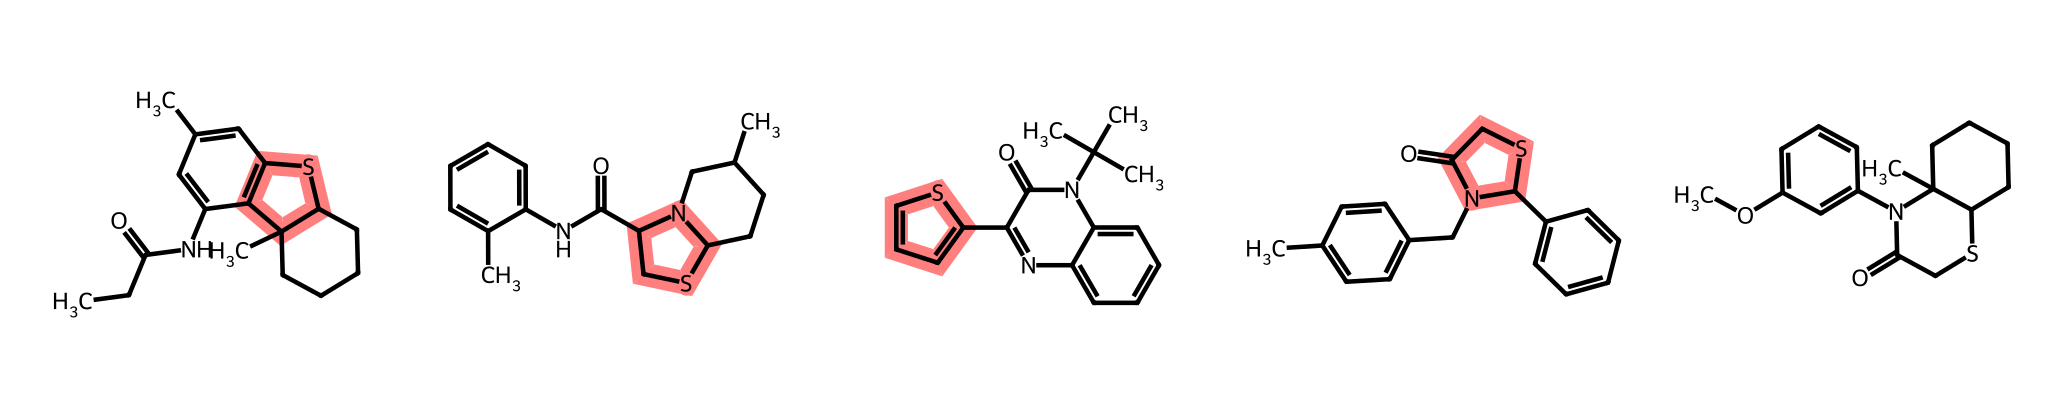

In [65]:
mols = all_results["pure_moldiff"]["mols"]
logdens = all_results["pure_moldiff"]["logdens_no_h"]
mols_to_draw = [
    mols[i] for i in np.argsort(logdens)[-5:]
]
highlights = [
    get_highlightable_atoms(mol, lactam_patt, thio_ring_patt, four_membered_amine, add_thiophene_patt)
    for mol in mols_to_draw
]
img = Draw.MolsToGridImage(
    mols_to_draw, molsPerRow=5, subImgSize=(450, 450), highlightAtomLists=highlights, drawOptions=dopts, useSVG=True
)
img

In [22]:
all_results.keys()

dict_keys(['inv_sum_gui_is_only_low_t_no_h_ref', 'direct_sum_gui_is', 'direct_sum_gui_no_is_no_h_ref', 'direct_sum_gui_no_is', 'inv_sum_gui_no_is', 'inv_sum_gui_is_low_t', 'direct_sum_gui_is_only_low_t', 'inv_sum_gui_no_is_no_h_ref', 'direct_sum_gui_is_low_t', 'pure_moldiff', 'direct_sum_gui_is_low_t_no_h_ref', 'inv_sum_gui_is_low_t_no_h_ref', 'inv_sum_gui_is_only_no_h_ref', 'direct_sum_gui_is_no_h_ref', 'inv_sum_gui_is', 'direct_sum_gui_is_only', 'inv_sum_gui_is_only', 'direct_sum_gui_is_only_no_h_ref', 'inv_sum_gui_is_no_h_ref', 'inv_sum_gui_is_only_low_t', 'direct_sum_gui_is_only_low_t_no_h_ref', 'fixed_scaffoled_no_readd_noise', 'fixed_scaffoled_readd_noise'])

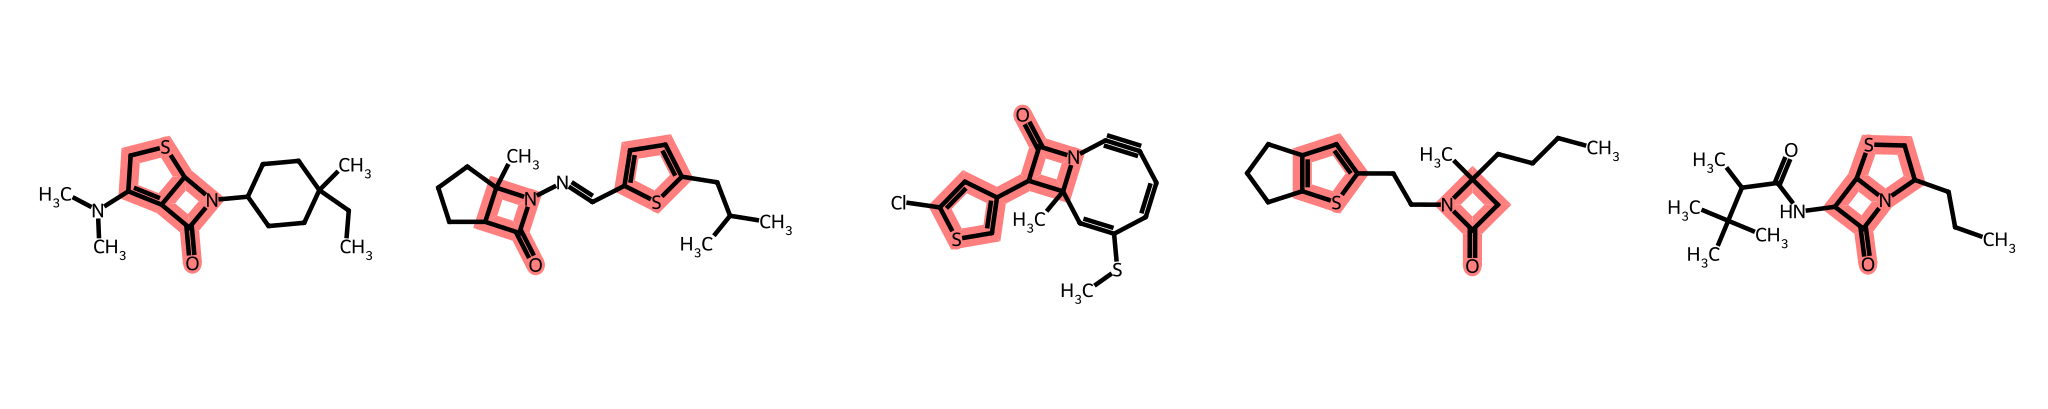

In [66]:
mols = all_results["inv_sum_gui_is_no_h_ref"]["mols"]
logdens = all_results["inv_sum_gui_is_no_h_ref"]["logdens_no_h"]
mols_to_draw = [
    mols[i] for i in np.argsort(logdens)[-5:]
]
highlights = [
    get_highlightable_atoms(mol, lactam_patt, thio_ring_patt, four_membered_amine, add_thiophene_patt)
    for mol in mols_to_draw
]
img = Draw.MolsToGridImage(
    mols_to_draw, molsPerRow=5, subImgSize=(450, 450), highlightAtomLists=highlights, drawOptions=dopts, useSVG=True
)
img